In [1]:
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #serpara los datos 
from sklearn.metrics import confusion_matrix, classification_report #estos los regulatado las claisigfacion y la matriz de confusion
from sklearn.preprocessing import StandardScaler #normalizar los datos 

In [2]:

def to_classlabel(z):
    return z.argmax(axis = 1) #etiqeuta en la columna



In [3]:
#y susecion de numeros, 
def one_hot_encode(y):
    n_class = np.unique(y).shape[0] #cunatas clases tiene Y 
    y_encode = np.zeros((y.shape[0], n_class)) #inicialzia la tabla, rengloes(instancias ) columnas numero de clases
    for idx, val in enumerate(y):
        y_encode[idx, val] = 1.0
    return y_encode


In [4]:
# Define Accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc #presicion 



In [ ]:
class Logistic_Regression_GDX():
    
    def __init__(self, lambda_param=0.01):
        self.theta = None
        self.lambda_param = lambda_param 
        
    
    """modificacion
    def _sigmoid(self, A, theta ):
        # Linear model: yh = A * theta
        yh = np.dot(A, theta) #hipoetsis 
        # Sigmoid function 1 / (1 + e^(-yh))
        return 1/(1 + np.exp(-yh)) #funcion logistica 
    """
    def _sigmoid(self, A, theta):
        yh = np.dot(A, theta)
    
        yh = np.clip(yh, -500, 500)
        return 1/(1 + np.exp(-yh))



   
    def _loss(self, y, h):
        '''
        a really small value 'epsilon' is added to avoid 
        overflow and divison by zero error for log
        loss = (-1/q) * sum(y * log(h) + (1-y) * log(1 - h))
        where h = 1/(1 + e^(-yh))
        '''
        epsilon = 1e-5
        h = np.clip(h, epsilon, 1 - epsilon)
        bce = - (y * np.log(h) + (1 - y) * np.log(1 - h))
        bce_loss = np.mean(bce)
        reg_term = (self.lambda_param/(2*len(y))) * np.sum(self.theta[1:]**2)
        return bce_loss + reg_term

    def fit(self, A, y, learning_rate=0.01, momentum=0.9, 
        lr_dec=0.5, lr_inc=1.05, max_perf_inc=1.04,
        epochs=100, batch_size=32, show_step=10, 
        stopping_threshold=1e-6, verbose=False):

        self.theta = np.random.randn(A.shape[1]) * 0.01   
        n_obs = A.shape[0]
        batch_loss = []
        epoch_loss = []
        delta_theta = np.zeros_like(self.theta)
        lr = learning_rate
        previous_loss = np.inf

        for e in range(epochs+1):
            THETA_prev = self.theta.copy()
            loss_e = 0
        
        
            indices = np.random.permutation(n_obs)
            A_shuffled = A[indices]
            y_shuffled = y[indices]

            
        
            # Calcular número de lotes completos y residual
            n_batches = n_obs // batch_size
            residual = n_obs % batch_size
            total_batches = n_batches + (1 if residual != 0 else 0)
        
            for batch_idx in range(total_batches):
           
                start = batch_idx * batch_size
                end = start + batch_size
                if batch_idx == n_batches and residual != 0:
                    end = start + residual
                
                A_batch = A_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                y_pred = self._sigmoid(A_batch, self.theta)
                loss = self._loss(y_batch, y_pred)
                loss_e += loss
                batch_loss.append(loss)
            
             
                grad = (1/len(A_batch)) * np.dot(y_pred - y_batch, A_batch)
                grad[1:] += (self.lambda_param/len(A_batch)) * self.theta[1:]
            
                
                delta_theta = momentum * delta_theta - (1 - momentum) * lr * grad
                self.theta += delta_theta
        
           
            if loss_e > previous_loss * max_perf_inc:
                self.theta = THETA_prev
                lr *= lr_dec
            elif loss_e < previous_loss:
                lr *= lr_inc
            
            epoch_loss.append(loss_e)
        
          
            if abs(previous_loss - loss_e) < stopping_threshold:
                if verbose:
                    print(f"Early stopping at epoch {e}")
                break
            
            previous_loss = loss_e
        
            if verbose and e % show_step == 0:
                print(f'Epoch: {e}, Loss: {loss_e:.3e}, lr: {lr:.2e}')
            
        return self.theta, batch_loss, epoch_loss
                
    def predict(self, A, threshold):
        y_predicted = self._sigmoid(A, self.theta)  #make prediction
        # Assign prediction to a class: 
        # if pred >= threshold then 1 else 0 and return as an array
        y_predicted_cls = [1 if i >= threshold else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

In [ ]:
class Logistic_Regression_GDX_Multiclass():
    def __init__(self, lambda_param=0.01, num_classes=6):
        self.models = []
        self.losses = []  
        self.lambda_param = lambda_param
        self.num_classes = num_classes

        
    def fit(self, A, y, **fit_params):
        self.models = []
        self.losses = []  
        
        for i in range(self.num_classes):
            y_binary = np.where(y == i, 1, 0)
            
            positive_indices = np.where(y_binary == 1)[0]
            negative_indices = np.where(y_binary == 0)[0]
            
            n_pos = len(positive_indices)
            
            if n_pos > 0:
                neg_selected = np.random.choice(negative_indices, size=n_pos, replace=False)
                
                balanced_indices = np.concatenate([positive_indices, neg_selected])
                np.random.shuffle(balanced_indices)
                
                A_balanced = A[balanced_indices]
                y_balanced = y_binary[balanced_indices]
            else:
                print(f"Advertencia: Clase {i} tiene 0 muestras positivas")
                A_balanced = A
                y_balanced = y_binary
            model = Logistic_Regression_GDX(lambda_param=self.lambda_param)
            theta, batch_loss, epoch_loss = model.fit(A_balanced, y_balanced, **fit_params)
            self.models.append(model)
            self.losses.append(epoch_loss)  
    
    def predict_proba(self, A):
        probas = []
        for model in self.models:
   
            proba = 1 / (1 + np.exp(-np.dot(A, model.theta)))
            probas.append(proba)
        return np.array(probas).T
    
    def predict(self, A):
        probas = self.predict_proba(A)
        return np.argmax(probas, axis=1)



In [7]:


# # Read the data
# data = np.loadtxt('admisiones_dataset.txt',delimiter=',')
# inputs = data[:,0:2]
# idx = 2-data[:,2] #restamos el 1 para establecer el categorico, adminitivos - 1 no admitivos - 0 
# targets = np.array(idx, dtype=int)     # codificacion categorica
# # targets = one_hot_encode(labels)      # one hot encode to classlabel


# Leer datos desde archivo dermatology.dat
# Reemplazar la sección de lectura de datos con:
try:
    # Leer el archivo .dat
    df = pd.read_csv('dermatology.dat', header=None, na_values='?', delimiter=r'\s+')
    
   
    inputs = df.iloc[:, 0:34]
    targets = df.iloc[:, 34]
    
  
    age_mean = inputs[33].mean()
    inputs[33] = inputs[33].fillna(age_mean)
    
    # Convertir todo a tipo float
    inputs = inputs.astype(float)
    targets = targets.astype(int) - 1  # Convertir clases de [1-6] a [0-5]

except Exception as e:
    print(f"Error al leer el archivo: {e}")
    exit()



C:\Users\erikG\AppData\Local\Temp\ipykernel_12988\1471213199.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs[33] = inputs[33].fillna(age_mean)


In [8]:

# Split the data
# x_train,x_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.40,random_state=1234) # test_size genreta entrenamiento y prueba 

# División de datos
x_train, x_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.3, random_state=42
)



In [9]:
scaler = StandardScaler()
x_train_= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)


In [10]:

#matrices de disenio, 
A_train = np.c_[np.ones(len(x_train)), x_train]
A_test = np.c_[np.ones(len(x_test)), x_test]


In [11]:


# Parámetros para el constructor

#minilot4es
# Hiperparámetros GDX 
# lambda_param = 0.01  
# fit_params = {
#     'learning_rate': 1e-2,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 64,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }


#online
# lambda_param = 0.01 
# fit_params = {
#     'learning_rate': 1e-2,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 1,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }


# #online
lambda_param = 0.01 
fit_params = {
    'learning_rate': 1e-2,
    'momentum': 0.95,
    'lr_dec': 0.5,
    'lr_inc': 1.05,
    'max_perf_inc': 1.04,
    'epochs': 300,
    'batch_size': len(y_train),
    'show_step': 50,
    'stopping_threshold': 1e-4,
    'verbose': True
}

In [12]:


# # Build and fit best LR model
# alpha = 0.01 #lr
# maxEpochs = 5000
# batch = 10 #minilotes
# show = 500 #view

# # Build model
# log_model = Logistic_Regression()
# # Fit Model
# theta, batch_loss, epoch_loss = log_model.fit(A_train, y_train, learning_rate=alpha, 
#                                 epochs=maxEpochs, batch_size=batch, show_step = show, verbose=True)


#---------------------------------------
# Entrenamiento del modelo dermatology.dat
model = Logistic_Regression_GDX_Multiclass(lambda_param=lambda_param, num_classes=6)
model.fit(A_train, y_train, **fit_params)

Epoch: 0, Loss: 6.803e-01, lr: 1.05e-02
Epoch: 50, Loss: 1.813e-01, lr: 1.20e-01
Epoch: 100, Loss: 2.744e-02, lr: 1.38e+00
Epoch: 150, Loss: 3.753e-03, lr: 1.58e+01
Early stopping at epoch 156
Epoch: 0, Loss: 7.043e-01, lr: 1.05e-02
Epoch: 50, Loss: 3.458e-01, lr: 9.91e-02
Epoch: 100, Loss: 1.420e-01, lr: 5.41e-01
Early stopping at epoch 101
Epoch: 0, Loss: 7.769e-01, lr: 1.05e-02
Epoch: 50, Loss: 1.158e-01, lr: 9.91e-02
Epoch: 100, Loss: 9.413e-03, lr: 1.14e+00
Early stopping at epoch 132
Epoch: 0, Loss: 6.937e-01, lr: 1.05e-02
Epoch: 50, Loss: 3.703e-01, lr: 1.20e-01
Epoch: 100, Loss: 9.542e-02, lr: 1.38e+00
Early stopping at epoch 104
Epoch: 0, Loss: 8.663e-01, lr: 1.05e-02
Early stopping at epoch 6
Epoch: 0, Loss: 7.285e-01, lr: 1.05e-02
Epoch: 50, Loss: 1.183e-01, lr: 9.43e-02
Epoch: 100, Loss: 1.067e-02, lr: 1.08e+00
Early stopping at epoch 128


In [13]:
max_length = max(len(loss_list) for loss_list in model.losses)
losses_array = np.full((len(model.losses), max_length), np.nan)
for i, loss_list in enumerate(model.losses):
    losses_array[i, :len(loss_list)] = loss_list
avg_epoch_loss = np.nanmean(losses_array, axis=0)

In [14]:

# Predicciones y evaluación
# Predicciones
train_pred = model.predict(A_train)
test_pred = model.predict(A_test)

In [15]:

print("rendimiento en entrenamiento (multiclase):")
print(f'Accuracy: {accuracy(y_train, train_pred):.4f}')
print("\nmatriz de confusion:")
print(confusion_matrix(y_train, train_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_train, train_pred))

rendimiento en entrenamiento (multiclase):
Accuracy: 0.7812

matriz de confusion:
[[72  0  0  0  0  0]
 [ 0 45  0  0  0  0]
 [ 0  0 53  0  0  0]
 [ 0 32  0  2  0  0]
 [ 0 24  0  0 12  0]
 [ 0  0  0  0  0 16]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.45      1.00      0.62        45
           2       1.00      1.00      1.00        53
           3       1.00      0.06      0.11        34
           4       1.00      0.33      0.50        36
           5       1.00      1.00      1.00        16

    accuracy                           0.78       256
   macro avg       0.91      0.73      0.70       256
weighted avg       0.90      0.78      0.74       256



In [16]:
print("\nrendimiento en prueba (multiclase):")
print(f'Accuracy: {accuracy(y_test, test_pred):.4f}')
print("\nmatriz de confusion:")
print(confusion_matrix(y_test, test_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_test, test_pred))


rendimiento en prueba (multiclase):
Accuracy: 0.8818

matriz de confusion:
[[40  0  0  0  0  0]
 [ 0 15  0  1  0  0]
 [ 0  0 19  0  0  0]
 [ 0  1  0 14  0  0]
 [ 0  5  0  6  5  0]
 [ 0  0  0  0  0  4]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.71      0.94      0.81        16
           2       1.00      1.00      1.00        19
           3       0.67      0.93      0.78        15
           4       1.00      0.31      0.48        16
           5       1.00      1.00      1.00         4

    accuracy                           0.88       110
   macro avg       0.90      0.86      0.84       110
weighted avg       0.91      0.88      0.87       110



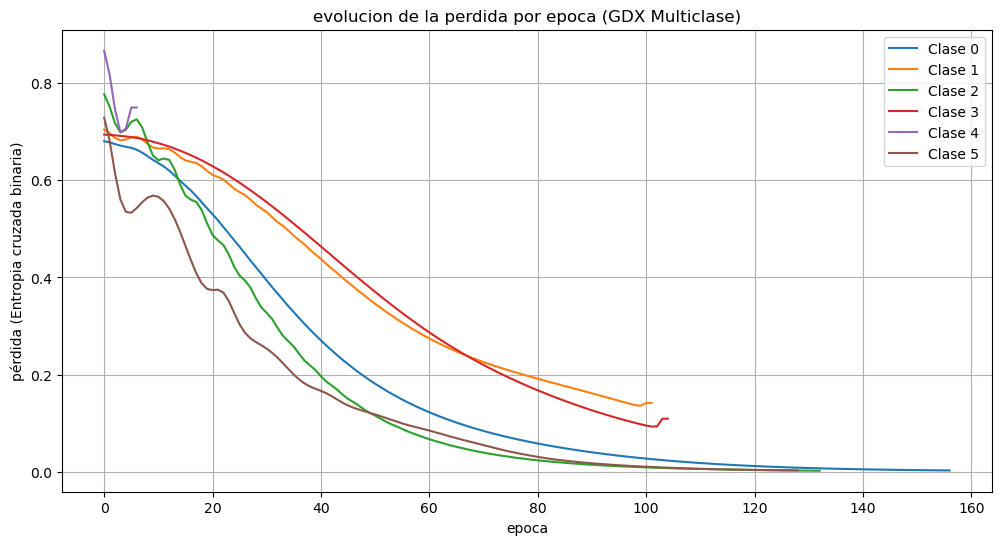

In [17]:


# Gráfica de pérdida
# Gráfica de pérdida
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(avg_epoch_loss, 'b-', linewidth=2)  # Usar avg_epoch_loss
# plt.title('Evolución de la Pérdida por Época')
# plt.xlabel('Época')
# plt.ylabel('Pérdida (Entropía Cruzada Binaria)')
# plt.grid(True)


plt.figure(figsize=(12, 6))
for i, loss_list in enumerate(model.losses):
    plt.plot(loss_list, label=f'Clase {i}')
plt.title('evolucion de la perdida por epoca (GDX Multiclase)')
plt.xlabel('epoca')
plt.ylabel('perdida (Entropia cruzada binaria)')
plt.legend()
plt.grid(True)
plt.show()




